In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import joblib

df = pd.read_csv("train_features.csv")
X = df.drop(columns=["label" , "en_label"]).values

scaler = joblib.load("scaler.pkl")

X_scaled = scaler.transform(X)

pca = PCA(n_components=0.9) 
X_scaled = pca.fit_transform(X_scaled)
pca_vis = PCA(n_components=2, random_state=42)
X_pca = pca_vis.fit_transform(X_scaled)


# Store results
results = {}

In [7]:
# Determine optimal k via silhouette
sil_scores_kmeans = []
k_range = range(2, 8)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores_kmeans.append(silhouette_score(X_scaled, labels))

best_k = k_range[np.argmax(sil_scores_kmeans)]
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)
results["K-Means"] = {
    "labels": labels_kmeans,
    "silhouette": max(sil_scores_kmeans),
    "k": best_k
}
print(f"K-Means: best k={best_k}, silhouette={max(sil_scores_kmeans):.3f}")

K-Means: best k=7, silhouette=0.327


In [8]:
from sklearn.mixture import GaussianMixture
sil_scores_gmm = []
bic_scores = []
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type='full')
    labels = gmm.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores_gmm.append(sil)
    bic_scores.append(gmm.bic(X_scaled))

best_k_gmm = k_range[np.argmax(sil_scores_gmm)]
gmm = GaussianMixture(n_components=best_k_gmm, random_state=42, covariance_type='full')
labels_gmm = gmm.fit_predict(X_scaled)
results["GMM"] = {
    "labels": labels_gmm,
    "silhouette": max(sil_scores_gmm),
    "k": best_k_gmm,
    "BIC": min(bic_scores)
}
print(f"GMM: best k={best_k_gmm}, silhouette={max(sil_scores_gmm):.3f}")

GMM: best k=7, silhouette=0.330


Agglomerative: best k=7, silhouette=0.325


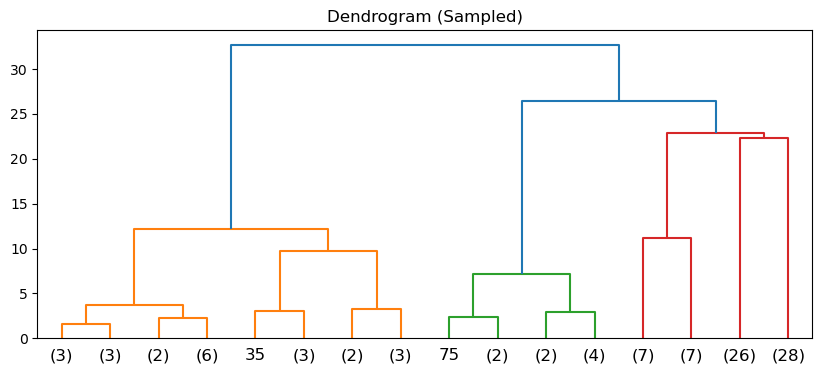

In [ ]:
# Try different linkage methods; use 'ward' (requires euclidean + scaled data)
sil_scores_agg = []
for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_scaled)
    sil_scores_agg.append(silhouette_score(X_scaled, labels))

best_k_agg = k_range[np.argmax(sil_scores_agg)]
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage='ward')
labels_agg = agg.fit_predict(X_scaled)
results["Agglomerative"] = {
    "labels": labels_agg,
    "silhouette": max(sil_scores_agg),
    "k": best_k_agg
}
print(f"Agglomerative: best k={best_k_agg}, silhouette={max(sil_scores_agg):.3f}")

# Optional: Dendrogram (on a sample due to O(n²) cost)
if X_scaled.shape[0] <= 1000:  # Only if dataset is small
    plt.figure(figsize=(10, 4))
    linked = linkage(X_scaled[:100], method='ward')  # Sample 100 points
    dendrogram(linked, truncate_mode='level', p=3)
    plt.title("Dendrogram (Sampled)")
    plt.savefig("img/dendrogram.png")
    plt.show()

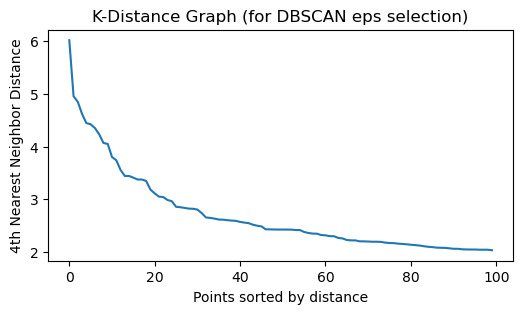

DBSCAN: 13 clusters, silhouette=0.343


In [ ]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=4)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
k_dist = np.sort(distances[:, -1])[::-1]

# Plot to choose eps (elbow point)
plt.figure(figsize=(6, 3))
plt.plot(k_dist[:100])  # First 100 points often enough
plt.title("K-Distance Graph (for DBSCAN eps selection)")
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.savefig("img/dbscan_k_distance.png")
plt.show()

# Use a reasonable eps (e.g., 0.5–1.0 after inspection); min_samples=5
eps = 2.2  # Adjust based on plot
dbscan = DBSCAN(eps=eps, min_samples=8)
labels_dbscan = dbscan.fit_predict(X_scaled)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
sil_dbscan = silhouette_score(X_scaled, labels_dbscan) if n_clusters_dbscan > 1 else -1

results["DBSCAN"] = {
    "labels": labels_dbscan,
    "silhouette": sil_dbscan,
    "n_clusters": n_clusters_dbscan,
    "eps": eps
}
print(f"DBSCAN: {n_clusters_dbscan} clusters, silhouette={sil_dbscan:.3f}")

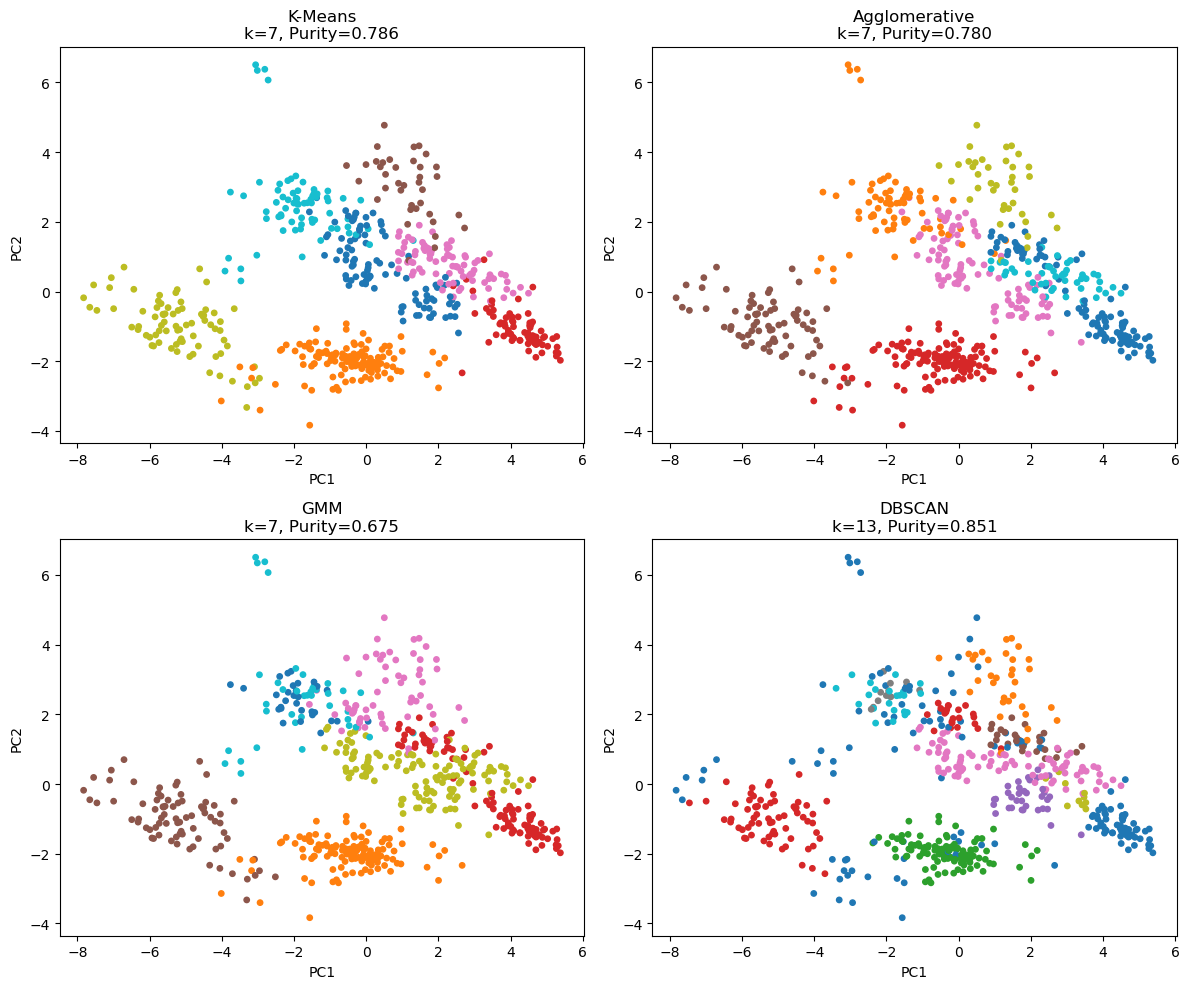

In [ ]:
# First, compute purity for each method
def cluster_purity(cluster_labels, true_labels):
    total = len(true_labels)
    purity = 0
    for cluster_id in np.unique(cluster_labels):
        mask = cluster_labels == cluster_id
        cluster_true = true_labels[mask]
        if len(cluster_true) == 0:
            continue
        most_common = np.bincount(cluster_true).max()
        purity += most_common
    return purity / total


true_labels = df["en_label"]

# Compute purity for each method and store in results
for method in results:
    labels = results[method]["labels"]
    purity = cluster_purity(labels, true_labels)
    results[method]["purity"] = purity

# Now plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
methods = ["K-Means", "Agglomerative", "GMM", "DBSCAN"]

for i, method in enumerate(methods):
    if method in results:
        labels = results[method]["labels"]
        scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", s=15)
        
        # Get k or n_clusters
        k_val = results[method].get('k', results[method].get('n_clusters', '?'))
        purity_val = results[method]["purity"]
        
        axes[i].set_title(f"{method}\nk={k_val}, Purity={purity_val:.3f}")
        axes[i].set_xlabel("PC1")
        axes[i].set_ylabel("PC2")
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.savefig("img/clustering_train_results.png")
plt.show()

In [14]:
# Save individual models
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(gmm, "gmm_model.pkl")
joblib.dump(agg, "agglomerative_model.pkl")
joblib.dump(dbscan, "dbscan_model.pkl")

# Save results dictionary with all metrics
joblib.dump(results, "clustering_results.pkl")

# Save PCA for visualization
joblib.dump(pca_vis, "pca_vis.pkl")

['pca_vis.pkl']